## Proovedores de Internet en Argentina 

> Análisis de las quejas realizadas por usuarios de Twitter hacia los distintos proveedores de internet de la República Argentina. Todo este análisis se realiza con el fin de poder derterminar cual es el que tiene menos quejas en relación con la cantidad de clientes.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rflor\AppData\Roaming\nltk_data...


True

### Primero realizamos la conexión entre Python y SQL Server 

In [1]:
import pyodbc
import sqlalchemy as sal
from sqlalchemy import create_engine
import pandas as pd
server = 'hxsqldev02\sql2016'
database = 'Academy_Dev_Data_RFlor'
driver = 'SQL Server'
engine = sal.create_engine(f'mssql://{server}/{database}?driver={driver}')
conn = engine.connect()
print(engine.table_names())

<ipython-input-1-674a419c6e52>:10: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(engine.table_names())


['dim_dates', 'dim_times', 'dim_users', 'dim_wifi_providers', 'fact_quotes', 'fact_replies', 'fact_retweets', 'fact_tweets', 'locations', 'raw_tweets', 'severity_data', 'trips']


### Empresas con mayor presencia en el mercado

> El análisis de Pareto consiste en quedarse con, en este caso los proveedores, que concentran la mayor cantidad de quejas. Esta regla también es conocida como 80-20, explicando que el 80% de los problemas surjen de solo el 20% de la población.

<Figure size 1800x1296 with 0 Axes>

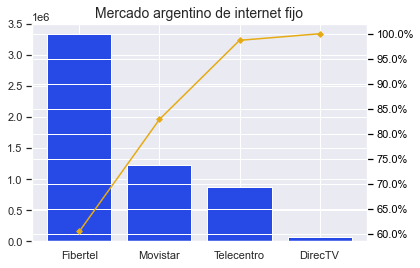

In [77]:
import matplotlib.pyplot as plt
'''from matplotlib.ticker import PercentFormatter

total = 7248280
fib_tot = 0.46*total
mov_tot = 0.17*total
tele_tot = 0.12*total
direc_tot = 0.01*total
#otros_tot = 0.24*total

plt.figure(figsize=(25,18))
df = pd.DataFrame({'wp_num_users': [fib_tot, mov_tot, tele_tot, direc_tot]})
df.index = ['Fibertel', 'Movistar', 'Telecentro', 'DirecTV']
df = df.sort_values(by='wp_num_users',ascending=False)
df["cumpercentage"] = df["wp_num_users"].cumsum()/df["wp_num_users"].sum()*100


fig, ax = plt.subplots()
ax.bar(df.index, df["wp_num_users"], color="#274AE6")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="#E6AB13", marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y", colors="#000000")

plt.title('Mercado argentino de internet fijo', fontsize = 14)
plt.show()'''

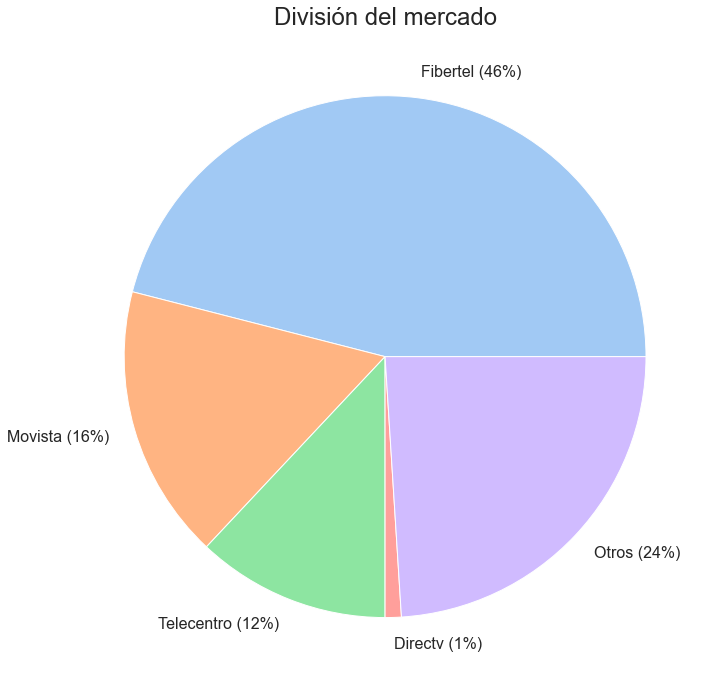

In [104]:



plt.figure(figsize=(12,12))
mercado=[0.46, 0.17, 0.12, 0.01, 0.24]
empresas = ['Fibertel (46%)', 'Movista (16%)', 'Telecentro (12%)', 'Directv (1%)', 'Otros (24%)']

# Create a pieplot
plt.title('División del mercado', fontsize=24)
plt.pie(mercado, labels=empresas, labeldistance=1.1, textprops={'fontsize': 16})
plt.show()



 


> Como se nota, hay 3 empresas que copan la mayoría del mercercado. Luego en la sección de 'otros' se encuentran empresas que trabajan en sectores puntuales y no vienen al caso de nuestro análisis.

>La fuente de los datos de porcentaje de mercado es de un informe de CABASE del año 2019, y del total de acceso a internet de un informe del INDEC.

>https://www.cabase.org.ar/wp-content/uploads/2019/12/CABASE-Internet-Index-II-Semestre-2019.pdf
>https://www.indec.gob.ar/uploads/informesdeprensa/internet_06_2134513C3A01.pdf

### Aplicación de NLTK

> Realizamos un análisis de severidad de las quejas realizadas por los usuarios para intentar conocer un poco más el grado de enojo de los mismos. 

>Esto lo hacemos a través del uso de  NLTK, la cual es un conjunto de bibliotecas y programas para el procesamiento del lenguaje natural (PLN) simbólico y estadísticos para Python.

In [45]:
#import nltk
#nltk.downloader.download('vader_lexicon')
from sqlalchemy import create_engine
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Obtengo a partir de los datos de la BD la información de todos los tweets,  quotes y replies para poder
# analizar la severidad de cada uno.
df_replies = pd.read_sql_query('SELECT * FROM fact_replies JOIN dim_wifi_providers dwp on fact_replies.rp_wifi_provider = dwp.wp_id', engine)
df_quotes = pd.read_sql_query('SELECT * FROM fact_quotes JOIN dim_wifi_providers dwp on fact_quotes.qu_wifi_provider = dwp.wp_id', engine)
df_tweets = pd.read_sql_query('SELECT * FROM fact_tweets JOIN dim_wifi_providers dwp on dwp.wp_id = fact_tweets.tw_wifi_provider', engine)

# Instancio al SentimentIntensityAnalyzer que me permite calcular la severidad
sia = SentimentIntensityAnalyzer()

# Aplico la función a cada dataframe
df_tweets['severity'] = df_tweets.apply(lambda row: sia.polarity_scores(str(row.tw_text))['compound'], axis=1)
df_replies['severity'] = df_replies.apply(lambda row: sia.polarity_scores(str(row.rp_text))['compound'], axis=1)
df_quotes['severity'] = df_quotes.apply(lambda row: sia.polarity_scores(str(row.qu_text))['compound'], axis=1)

# Creo un dataframe que concentre toda la información
df_severity = pd.DataFrame(columns=['wp_name', 'severity'])
df_severity = df_severity.append(df_tweets[['wp_name', 'severity']])
df_severity = df_severity.append(df_replies[['wp_name', 'severity']])
df_severity = df_severity.append(df_quotes[['wp_name', 'severity']])

# Droppeo los que sean mayores iguales a 0
index_names = df_severity[df_severity['severity'] >= 0].index

df_severity.drop(index_names, inplace=True)

# Agrupo el dataframe por empresa y calculo el promedio
df_severity = (df_severity.groupby(by="wp_name", dropna=True).mean())*-1

print(df_severity)

            severity
wp_name             
Claro       0.403132
DirecTV     0.409323
Fibertel    0.488588
Gigared     0.305483
Iplan       0.486620
Iptel       0.623775
Movistar    0.485944
Sion        0.472650
Telecentro  0.457752


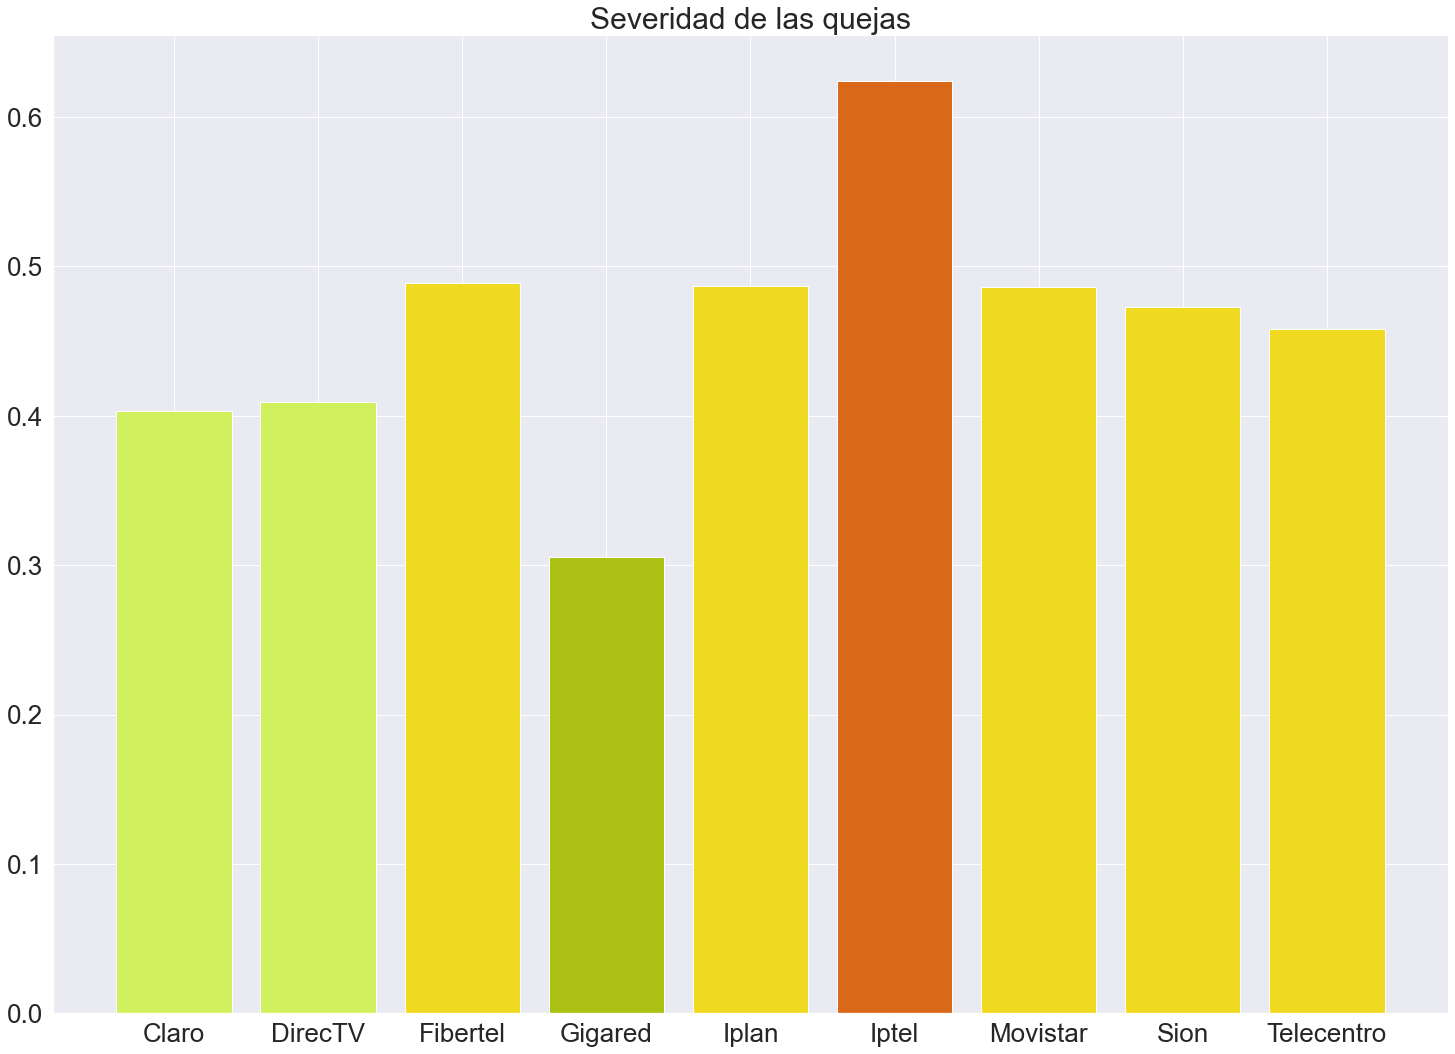

In [55]:
empresa = ['Claro','DirecTV', 'Fibertel', 'Gigared', 'Iplan', 'Iptel', 'Movistar', 'Sion', 'Telecentro']
severity = df_severity['severity']

plt.figure(figsize=(25,18))
plt.bar(empresa, df_severity['severity'], color=['#D0F05D', '#D0F05D', '#F0D921', '#ABC215', '#F0D921',
                                                 '#D96918', '#F0D921', '#F0D921', '#F0D921'])

plt.title('Severidad de las quejas', fontsize=30)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.show()

### Cantidad de quejas por empresa en este momento

In [5]:
df_totales = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) FROM dbo.fact_tweets where tw_wifi_provider = wp_id) as 'cant_tweets',
                                        (SELECT COUNT(*) FROM dbo.fact_retweets where rt_wifi_provider = wp_id) as 'cant_rts',
                                        (SELECT COUNT(*) FROM dbo.fact_quotes where qu_wifi_provider = wp_id) as 'cant_quotes',
                                        (SELECT COUNT(*) FROM dbo.fact_replies where rp_wifi_provider = wp_id) as 'cant_replies'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)

total = 7248280

df_totales.loc[df_totales.index[2], 'cant_usuarios'] = fib_tot = 0.46*total
df_totales.loc[df_totales.index[1], 'cant_usuarios'] = fib_tot = 0.01*total
df_totales.loc[df_totales.index[7], 'cant_usuarios'] = fib_tot = 0.17*total
df_totales.loc[df_totales.index[9], 'cant_usuarios'] = fib_tot = 0.12*total

df_totales['total'] = df_totales.apply(lambda row: row.cant_tweets + row.cant_replies + row.cant_quotes + row.cant_rts,axis=1)
df_totales.sort_values(by=['total'], ascending=False, inplace=True)
df_totales['porcentaje'] = (df_totales['total']/df_totales['cant_usuarios'])*100


print(df_totales)

       nombre  cant_tweets  cant_rts  cant_quotes  cant_replies  \
2    Fibertel         5136      1493          305          3419   
7    Movistar         1868      3796          563          2302   
9  Telecentro         1965       476           92          2406   
0       Claro          308       287           23           561   
1     DirecTV          121        12            3           121   
3     Gigared           96        28            9             5   
4       Iplan           19         5            0            11   
5       Iptel            6         0            0            10   
8        Sion            8         0            0             5   
6    Metrotel            4         1            0             0   

   cant_usuarios  total  porcentaje  
2      3334208.8  10353    0.310508  
7      1232207.6   8529    0.692172  
9       869793.6   4939    0.567836  
0            NaN   1179         NaN  
1        72482.8    257    0.354567  
3            NaN    138         Na

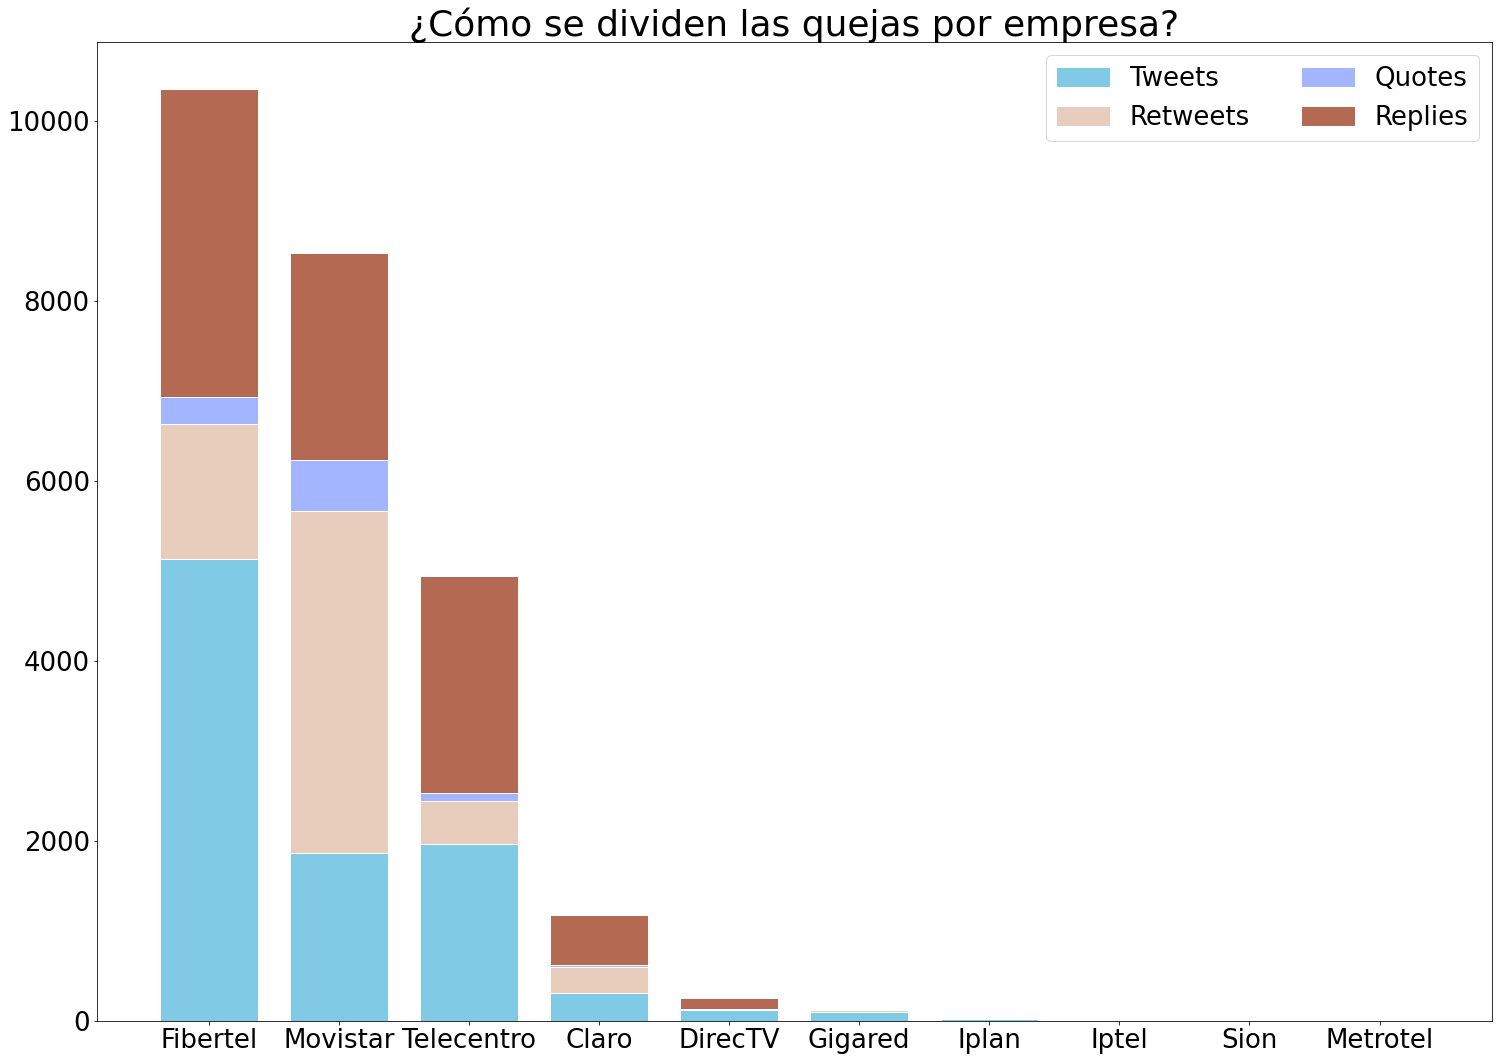

In [8]:
from matplotlib import rc
import matplotlib.patches as mpatches
import numpy as np

barWidth = 0.75
names = df_totales['nombre']
tw = df_totales['cant_tweets']
rt = df_totales['cant_rts']
qu = df_totales['cant_quotes']
re = df_totales['cant_replies']

plt.figure(figsize=(25,18))

# Create Tweets Bars
plt.bar(names, tw, color='#81CAE6', edgecolor='white', width=barWidth)
# Create Rts Bars
plt.bar(names, rt, bottom=tw, color='#E9CDBC', edgecolor='white', width=barWidth)
# Create Quotes Bars
plt.bar(names, qu, bottom=[i+j for i,j in zip(tw, rt)], color='#A3B5FF', edgecolor='white', width=barWidth)
# Create Replies Bars
plt.bar(names, re, bottom=[i+j+k for i,j,k in zip(tw, rt, qu)], color='#B36952', edgecolor='white', width=barWidth)

plt.title('¿Cómo se dividen las quejas por empresa?', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
tw_bar = mpatches.Patch(color='#81CAE6', label='Tweets')
rt_bar = mpatches.Patch(color='#E9CDBC', label='Retweets')
qu_bar = mpatches.Patch(color='#A3B5FF', label='Quotes')
re_bar = mpatches.Patch(color='#B36952', label='Replies')
plt.legend(handles=[tw_bar, rt_bar, qu_bar, re_bar],loc='upper right', ncol=2, fontsize=26)
plt.show()


>Notamos que Fibertel, Movistar y Telecentro acaparan la mayor parte de las quejas. Sim embargo esto puede no ser muy informativo sin antes compararlo con la cantidad de clientes

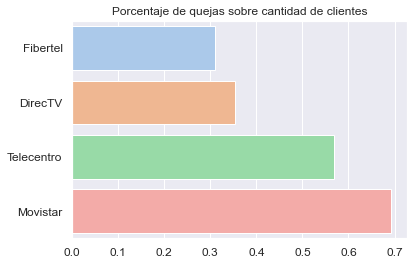

In [72]:
import seaborn as sns

empresas_ut =  [df_totales['nombre'][2], df_totales['nombre'][1],
                df_totales['nombre'][9],df_totales['nombre'][7]]
porcen_ut = [df_totales['porcentaje'][2], df_totales['porcentaje'][1],
             df_totales['porcentaje'][9],df_totales['porcentaje'][7]]


sns.set_palette("pastel")
#sns.set(style="darkgrid")
plt.title('Porcentaje de quejas sobre cantidad de clientes')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



sns.barplot(
    x=porcen_ut, 
    y=empresas_ut, 
    data=df_totales, 
    estimator=sum, 
    ci=None);


### ¿Hay más quejas en un horario específico? 

>Acá vamos a analizar en si hay algún momento específico del dia en dónde la gente se queje más

In [74]:
df_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_tweets
                                            JOIN dim_times dt on fact_tweets.tw_time = dt.ti_id
                                            where tw_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_tweets
                                            JOIN dim_times dt on fact_tweets.tw_time = dt.ti_id
                                            where tw_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_tweets
                                            JOIN dim_times dt on fact_tweets.tw_time = dt.ti_id
                                            where tw_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_tweets
                                            JOIN dim_times dt on fact_tweets.tw_time = dt.ti_id
                                            where tw_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)

df_rt_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)
df_rt_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_retweets
                                            JOIN dim_times dt on fact_retweets.rt_time = dt.ti_id
                                            where rt_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)
df_rp_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_replies
                                            JOIN dim_times dt on fact_replies.rp_time = dt.ti_id
                                            where rp_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_replies
                                            JOIN dim_times dt on fact_replies.rp_time = dt.ti_id
                                            where rp_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_replies
                                            JOIN dim_times dt on fact_replies.rp_time = dt.ti_id
                                            where rp_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_replies
                                            JOIN dim_times dt on fact_replies.rp_time = dt.ti_id
                                            where rp_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)

df_qu_horarios = pd.read_sql_query("""SELECT 
                                        wp_name as 'nombre',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_quotes
                                            JOIN dim_times dt on fact_quotes.qu_time = dt.ti_id
                                            where qu_wifi_provider = wp_id AND ti_hour >= 0 and ti_hour <= 5) as 'cant_madrugada',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_quotes
                                            JOIN dim_times dt on fact_quotes.qu_time = dt.ti_id
                                            where qu_wifi_provider = wp_id AND ti_hour >= 6 and ti_hour <= 12) as 'cant_maniana',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_quotes
                                            JOIN dim_times dt on fact_quotes.qu_time = dt.ti_id
                                            where qu_wifi_provider = wp_id AND ti_hour >= 13 and ti_hour <= 18) as 'cant_tarde',
                                        (SELECT COUNT(*) 
                                            FROM dbo.fact_quotes
                                            JOIN dim_times dt on fact_quotes.qu_time = dt.ti_id
                                            where qu_wifi_provider = wp_id AND ti_hour >= 19 and ti_hour <= 23) as 'cant_noche'
                                  FROM dbo.dim_wifi_providers
                                  ORDER BY 1 """, engine)


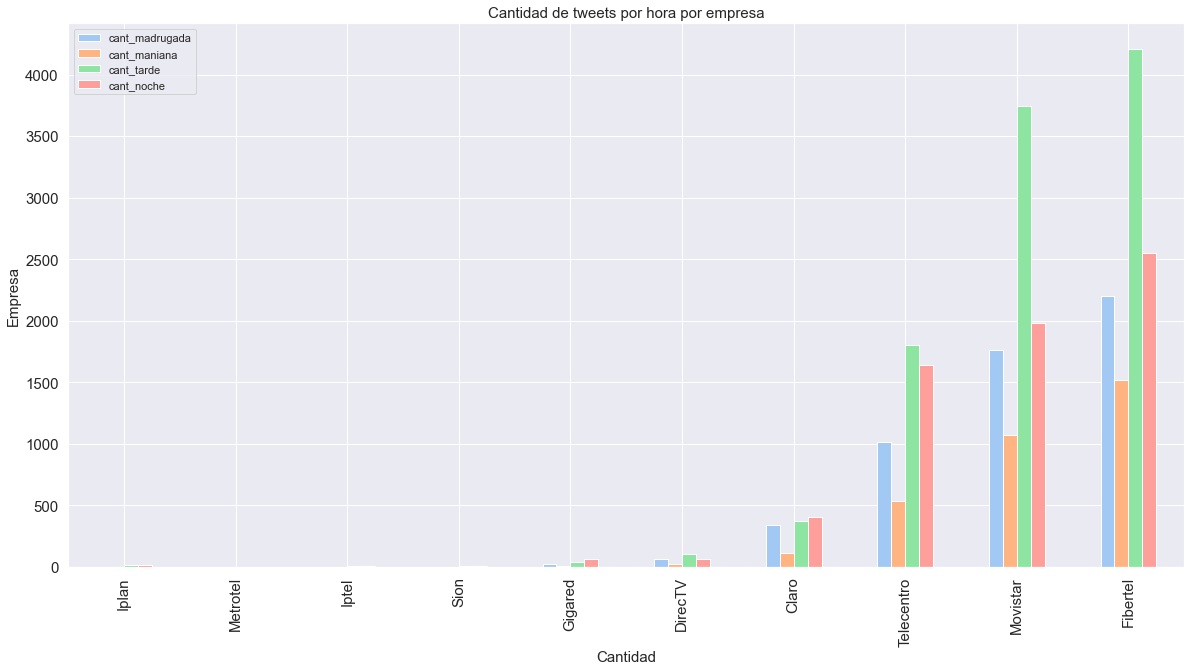

In [75]:
df_horarios = df_horarios.append(df_rt_horarios)
df_horarios = df_horarios.append(df_rp_horarios)
df_horarios = df_horarios.append(df_qu_horarios)
df_horarios = df_horarios.groupby(by='nombre').sum()

sns.set_palette("pastel")
df_horarios.sort_values('cant_madrugada',inplace=True)

df_horarios.plot(kind='bar',
             stacked=False,
             figsize=(20, 10))

plt.title('Cantidad de tweets por hora por empresa', fontsize=15)
plt.ylabel('Empresa', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Cantidad', fontsize=15)

plt.show()